# PR Forecast 2082: Model Diagnostics (Multi-Model)

This notebook compares feature influence across three model families:

- **Ridge** (linear baseline): standardized coefficients
- **ElasticNet** (linear sparse): standardized coefficients
- **XGBoost** (nonlinear challenger): feature importance

Notes:
- Linear coefficients include direction (+/-).
- Tree importance is nonnegative and scale differs; we compare via rank/normalized scores.


In [39]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, ElasticNet




In [40]:
os.chdir(r"C:\Users\dipes\Desktop\election-analytics-nepal-2082")
print(os.getcwd())

C:\Users\dipes\Desktop\election-analytics-nepal-2082


In [41]:
from src.features.transforms import add_derived_features


In [42]:
TRAIN_PATH = "data/processed/pr_train_2079.csv"
FEATURES_PATH = "models/artifacts/pr_feature_list.json"

FINAL_MODEL_PATH = "models/artifacts/pr_final_model.joblib"
XGB_MODEL_PATH = "models/artifacts/pr_winner_model_xgboost_trained_on_split.joblib"


In [43]:
with open(FEATURES_PATH, "r", encoding="utf-8") as f:
    FEATURES = json.load(f)

df = pd.read_csv(TRAIN_PATH)

#add derived features so FEATURE list exists
df = add_derived_features(df)

TARGET = "vote_share_change"
X = df[FEATURES]
y = df[TARGET]

X.shape, y.shape



((3619, 17), (3619,))

## Models included

We aim to extract importances for:
- Ridge (fit quickly if not saved)
- ElasticNet (fit quickly if not saved)
- XGBoost (load if artifact exists)

Linear models are fit with StandardScaler to make coefficients comparable across features.



In [44]:
ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0, random_state=42))
])
ridge.fit(X, y)

enet = Pipeline([
    ("scaler", StandardScaler()),
    ("model", ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=20000, random_state=42))
])
enet.fit(X, y)

type(ridge), type(enet)



(sklearn.pipeline.Pipeline, sklearn.pipeline.Pipeline)

In [45]:
xgb_model = None
if os.path.exists(XGB_MODEL_PATH):
    xgb_model = joblib.load(XGB_MODEL_PATH)
    print("Loaded XGB artifact:", type(xgb_model))
else:
    print("XGB artifact not found at:", XGB_MODEL_PATH)



Loaded XGB artifact: <class 'xgboost.sklearn.XGBRegressor'>


In [46]:
def extract_linear_coefs(pipe: Pipeline, feature_names: list[str]) -> pd.DataFrame:
    # assumes Pipeline(scaler, model)
    model = pipe.named_steps["model"]
    coefs = model.coef_
    out = pd.DataFrame({"feature": feature_names, "value": coefs})
    out["abs_value"] = out["value"].abs()
    out["model"] = type(model).__name__
    return out



In [47]:
def extract_xgb_importance(m, feature_names: list[str]) -> pd.DataFrame:
    if m is None:
        return pd.DataFrame(columns=["feature", "value", "abs_value", "model"])
    # Prefer gain if booster is available
    try:
        booster = m.get_booster()
        score = booster.get_score(importance_type="gain")
        # score keys are like 'f0','f1'...
        imp = np.zeros(len(feature_names), dtype=float)
        for k, v in score.items():
            if k.startswith("f"):
                idx = int(k[1:])
                if 0 <= idx < len(feature_names):
                    imp[idx] = v
        out = pd.DataFrame({"feature": feature_names, "value": imp})
    except Exception:
        # fallback
        if hasattr(m, "feature_importances_"):
            out = pd.DataFrame({"feature": feature_names, "value": m.feature_importances_})
        else:
            out = pd.DataFrame({"feature": feature_names, "value": np.zeros(len(feature_names))})

    out["abs_value"] = out["value"].abs()
    out["model"] = "XGBoost"
    return out



In [48]:
ridge_imp = extract_linear_coefs(ridge, FEATURES)
enet_imp = extract_linear_coefs(enet, FEATURES)
xgb_imp = extract_xgb_importance(xgb_model, FEATURES)

imp_all = pd.concat([ridge_imp, enet_imp, xgb_imp], ignore_index=True)
imp_all.head()


,feature,value,abs_value,model
0,vote_share_lag,-1.627763,1.627763,Ridge
1,is_new_party,0.141832,0.141832,Ridge
2,IS_Major?,-0.101914,0.101914,Ridge
3,Was_Part_Of_Ousted_Government?,0.203293,0.203293,Ridge
4,GenZ_and_Youth_Favored?,0.925314,0.925314,Ridge


## Visualization 1: Top features per model

We plot the top-N features by absolute importance:
- Ridge / ElasticNet: coefficient magnitude (with direction)
- XGBoost: gain-based importance (nonnegative)

Important: scales differ across model families, so interpret within-model first.



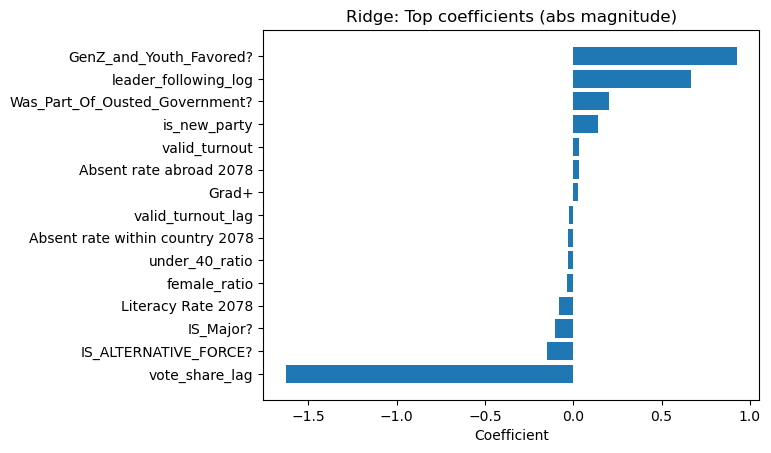

In [49]:
def plot_top_linear(df_imp: pd.DataFrame, title: str, top_n: int = 15):
    d = df_imp.sort_values("abs_value", ascending=False).head(top_n).sort_values("value")
    plt.figure()
    plt.barh(d["feature"], d["value"])
    plt.title(title)
    plt.xlabel("Coefficient")
    plt.ylabel("")
    plt.show()

plot_top_linear(ridge_imp, "Ridge: Top coefficients (abs magnitude)", top_n=15)


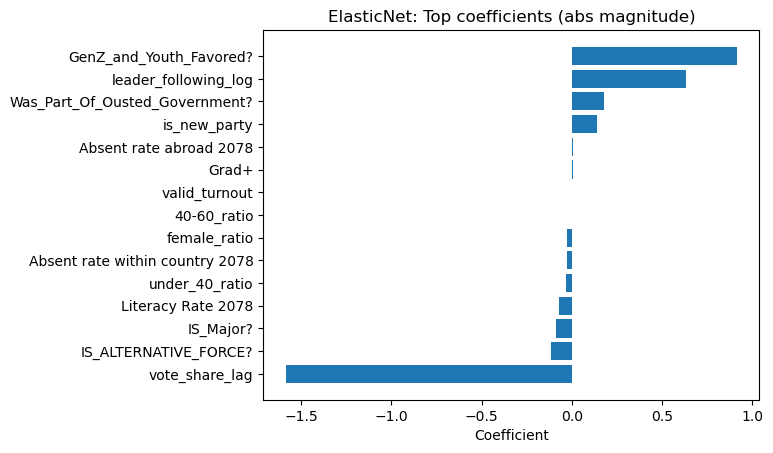

In [50]:
plot_top_linear(enet_imp, "ElasticNet: Top coefficients (abs magnitude)", top_n=15)



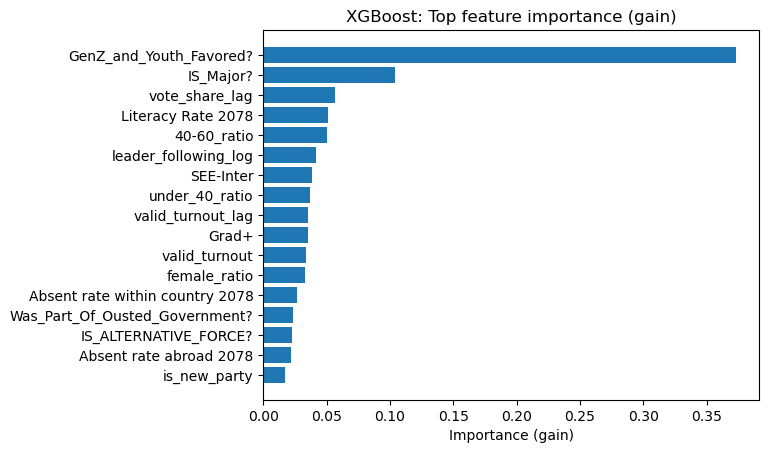

In [51]:
def plot_top_xgb(df_imp: pd.DataFrame, title: str, top_n: int = 20):
    d = df_imp.sort_values("value", ascending=False).head(top_n).sort_values("value")
    plt.figure()
    plt.barh(d["feature"], d["value"])
    plt.title(title)
    plt.xlabel("Importance (gain)")
    plt.ylabel("")
    plt.show()

if len(xgb_imp) and xgb_imp["value"].sum() > 0:
    plot_top_xgb(xgb_imp, "XGBoost: Top feature importance (gain)", top_n=20)
else:
    print("No XGBoost importance available (artifact missing or all zeros).")


## Visualization 2: Cross-model agreement (rank comparison)

Because scales differ, we compare **rank** and **normalized magnitude**.

Steps:
1) Convert each model's importances to a 0–1 normalized score within model
2) Compute rank (1 = most important)
3) Compare which features consistently appear in the top set


In [52]:
def normalize_within_model(df_imp: pd.DataFrame) -> pd.DataFrame:
    d = df_imp.copy()
    # For XGB use value; for linear use abs_value (magnitude)
    if d["model"].iloc[0] == "XGBoost":
        base = d["value"]
    else:
        base = d["abs_value"]

    denom = base.max()
    d["norm"] = (base / denom) if denom > 0 else 0.0
    d["rank"] = base.rank(ascending=False, method="min")
    return d[["feature", "model", "value", "abs_value", "norm", "rank"]]

ridge_n = normalize_within_model(ridge_imp)
enet_n = normalize_within_model(enet_imp)
xgb_n = normalize_within_model(xgb_imp)

norm_all = pd.concat([ridge_n, enet_n, xgb_n], ignore_index=True)
norm_all.head()


,feature,model,value,abs_value,norm,rank
0,vote_share_lag,Ridge,-1.627763,1.627763,1.000000,1.0
1,is_new_party,Ridge,0.141832,0.141832,0.087133,6.0
2,IS_Major?,Ridge,-0.101914,0.101914,0.062610,7.0
3,Was_Part_Of_Ousted_Government?,Ridge,0.203293,0.203293,0.124891,4.0
4,GenZ_and_Youth_Favored?,Ridge,0.925314,0.925314,0.568458,2.0


In [53]:
rank_tbl = norm_all.pivot_table(index="feature", columns="model", values="rank")
norm_tbl = norm_all.pivot_table(index="feature", columns="model", values="norm")

rank_tbl.head(), norm_tbl.head()



(model                            ElasticNet  Ridge  XGBoost
 feature                                                    
 40-60_ratio                            15.0   16.0      5.0
 Absent rate abroad 2078                12.0   13.0     16.0
 Absent rate within country 2078        10.0   11.0     13.0
 GenZ_and_Youth_Favored?                 2.0    2.0      1.0
 Grad+                                  13.0   15.0     10.0,
 model                            ElasticNet     Ridge   XGBoost
 feature                                                        
 40-60_ratio                        0.000000  0.008770  0.135456
 Absent rate abroad 2078            0.005830  0.018458  0.059095
 Absent rate within country 2078    0.016304  0.019263  0.070384
 GenZ_and_Youth_Favored?            0.576979  0.568458  1.000000
 Grad+                              0.004179  0.014366  0.093791)

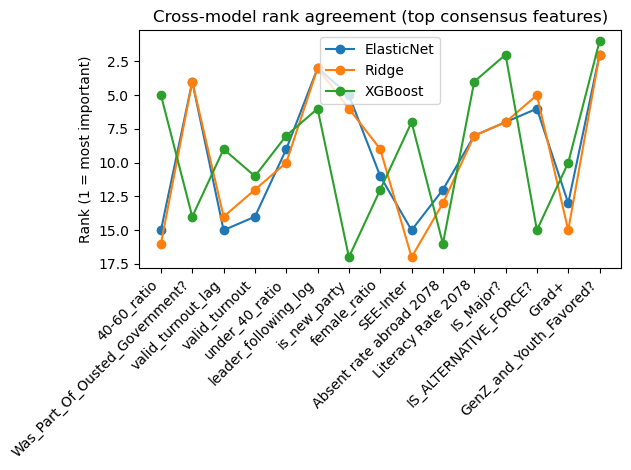

In [54]:
# pick features that are top in at least 2 models
feat = top_consensus[top_consensus["count_models_in_top"] >= 2].head(15).index.tolist()
r = rank_tbl.loc[feat].copy()

plt.figure()
for model_name in r.columns:
    plt.plot(r[model_name].values, marker="o", label=model_name)

plt.gca().invert_yaxis()  # rank 1 at top
plt.xticks(range(len(feat)), feat, rotation=45, ha="right")
plt.ylabel("Rank (1 = most important)")
plt.title("Cross-model rank agreement (top consensus features)")
plt.legend()
plt.tight_layout()
plt.show()


## Interpretation guide

- Features that rank highly across **both linear models and XGBoost** are likely robust signals.
- Features that are important only in XGBoost may indicate nonlinear interactions.
- Coefficient sign matters only for linear models (direction of predicted vote-share change).



In [55]:
out = (
    norm_all.sort_values(["model", "rank"])
    .reset_index(drop=True)
)

out.to_csv("data/outputs/pr_feature_importance_comparison.csv", index=False)
print("Saved: data/outputs/pr_feature_importance_comparison.csv")


Saved: data/outputs/pr_feature_importance_comparison.csv
